In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch.nn.functional as F
#注意loss的选择，这个搞完可以搞一个简易的双塔模型的，以及是否有历史数据和热启动

In [3]:
#双塔模型（问题在于，目前建立的所有模型都是基于用户的基本信息建立的画像，没有引入任何历史信息）
data1=pd.read_csv('data1.csv')
data1.drop(data1.columns[0], axis=1, inplace=True)
# 数据集类定义
class MovieRatingDataset(Dataset):
    def __init__(self, X_cat_user, X_cont_user, X_cat_item, X_cont_item, y):
        self.X_cat_user = torch.tensor(X_cat_user.values, dtype=torch.long)
        self.X_cont_user = torch.tensor(X_cont_user, dtype=torch.float32)
        self.X_cat_item = torch.tensor(X_cat_item.values, dtype=torch.long)
        self.X_cont_item = torch.tensor(X_cont_item, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_cat_user[idx], self.X_cont_user[idx], self.X_cat_item[idx], self.X_cont_item[idx], self.y[idx]
# 双塔模型类定义
class TwoTowerModel(nn.Module):
    def __init__(self, user_dims, item_dims, embedding_dim, num_user_cont_features, num_item_cont_features):
        super(TwoTowerModel, self).__init__()
        # 用户塔
        self.user_embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=input_dim) for input_dim in user_dims
        ])
        self.user_deep = nn.Sequential(
            nn.Linear(len(user_dims) * embedding_dim + num_user_cont_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64)#即使只是单纯的线性映射也可能有用
        )
        # 物品塔
        self.item_embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=input_dim) for input_dim in item_dims
        ])
        self.item_deep = nn.Sequential(
            nn.Linear(len(item_dims) * embedding_dim + num_item_cont_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
    def forward(self, user_cat, user_cont, item_cat, item_cont):
        # 用户塔前向传播
        user_cat_embeds = [self.user_embeddings[i](user_cat[:, i]) for i in range(len(self.user_embeddings))]
        user_cat_embeds = torch.cat(user_cat_embeds, dim=1)
        user_input = torch.cat([user_cat_embeds, user_cont], dim=1)
        user_out = self.user_deep(user_input)
        # 物品塔前向传播
        item_cat_embeds = [self.item_embeddings[i](item_cat[:, i]) for i in range(len(self.item_embeddings))]
        item_cat_embeds = torch.cat(item_cat_embeds, dim=1)
        item_input = torch.cat([item_cat_embeds, item_cont], dim=1)
        item_out = self.item_deep(item_input)
        similarity = F.cosine_similarity(user_out, item_out)
        # 将相似度映射到评分范围
        rating = (similarity + 1) * 2.5  
        return rating#通过简单的将余弦相似度输出结果缩放达到转换为评分，这里注意一下
def encode_features(df, label_encoders=None):
    encoded_df = df.copy()
    if label_encoders is None:
        label_encoders = {}
        for column in df.columns:
            le = LabelEncoder()
            encoded_df[column] = le.fit_transform(df[column])
            label_encoders[column] = le
    else:
        for column in df.columns:
            le = label_encoders[column]
            encoded_df[column] = le.transform(df[column])   
    return encoded_df, label_encoders

In [4]:
# 数据准备和模型训练
y = data1['rating']
X = data1.drop(columns=['rating'])
continuous_cols_user = ['timestamp', 'user id', 'age']
continuous_cols_item = ['release_date', 'item id']
categorical_cols_user = ["gender","occupation","zip code"]
categorical_cols_item = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_user_cat, user_label_encoders = encode_features(X_train[categorical_cols_user])
X_test_user_cat, _ = encode_features(X_test[categorical_cols_user], user_label_encoders)

X_train_item_cat, item_label_encoders = encode_features(X_train[categorical_cols_item])
X_test_item_cat, _ = encode_features(X_test[categorical_cols_item], item_label_encoders)

scaler_user = StandardScaler()
X_train_user_cont = scaler_user.fit_transform(X_train[continuous_cols_user])
X_test_user_cont = scaler_user.transform(X_test[continuous_cols_user])

scaler_item = StandardScaler()
X_train_item_cont = scaler_item.fit_transform(X_train[continuous_cols_item])
X_test_item_cont = scaler_item.transform(X_test[continuous_cols_item])

train_dataset = MovieRatingDataset(X_train_user_cat, X_train_user_cont, X_train_item_cat, X_train_item_cont, y_train)
test_dataset = MovieRatingDataset(X_test_user_cat, X_test_user_cont, X_test_item_cat, X_test_item_cont, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [62]:
# 根据特征维度初始化双塔模型
user_dims = [X_train_user_cat[col].nunique() for col in categorical_cols_user]
item_dims = [X_train_item_cat[col].nunique() for col in categorical_cols_item]
model = TwoTowerModel(user_dims, item_dims, embedding_dim=8, num_user_cont_features=len(continuous_cols_user), num_item_cont_features=len(continuous_cols_item))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for user_cat_batch, user_cont_batch, item_cat_batch, item_cont_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(user_cat_batch, user_cont_batch, item_cat_batch, item_cont_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * user_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for user_cat_batch, user_cont_batch, item_cat_batch, item_cont_batch, _ in test_loader:
        outputs = model(user_cat_batch, user_cont_batch, item_cat_batch, item_cont_batch).squeeze()
        y_pred.extend(outputs.numpy())

y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')

Epoch 1/50, Loss: 1.1087
Epoch 2/50, Loss: 1.0257
Epoch 3/50, Loss: 0.9926
Epoch 4/50, Loss: 0.9757
Epoch 5/50, Loss: 0.9649
Epoch 6/50, Loss: 0.9526
Epoch 7/50, Loss: 0.9444
Epoch 8/50, Loss: 0.9342
Epoch 9/50, Loss: 0.9276
Epoch 10/50, Loss: 0.9204
Epoch 11/50, Loss: 0.9137
Epoch 12/50, Loss: 0.9098
Epoch 13/50, Loss: 0.9021
Epoch 14/50, Loss: 0.8963
Epoch 15/50, Loss: 0.8925
Epoch 16/50, Loss: 0.8860
Epoch 17/50, Loss: 0.8806
Epoch 18/50, Loss: 0.8755
Epoch 19/50, Loss: 0.8723
Epoch 20/50, Loss: 0.8662
Epoch 21/50, Loss: 0.8620
Epoch 22/50, Loss: 0.8592
Epoch 23/50, Loss: 0.8543
Epoch 24/50, Loss: 0.8510
Epoch 25/50, Loss: 0.8483
Epoch 26/50, Loss: 0.8442
Epoch 27/50, Loss: 0.8414
Epoch 28/50, Loss: 0.8382
Epoch 29/50, Loss: 0.8355
Epoch 30/50, Loss: 0.8315
Epoch 31/50, Loss: 0.8293
Epoch 32/50, Loss: 0.8262
Epoch 33/50, Loss: 0.8241
Epoch 34/50, Loss: 0.8207
Epoch 35/50, Loss: 0.8181
Epoch 36/50, Loss: 0.8148
Epoch 37/50, Loss: 0.8128
Epoch 38/50, Loss: 0.8107
Epoch 39/50, Loss: 0.

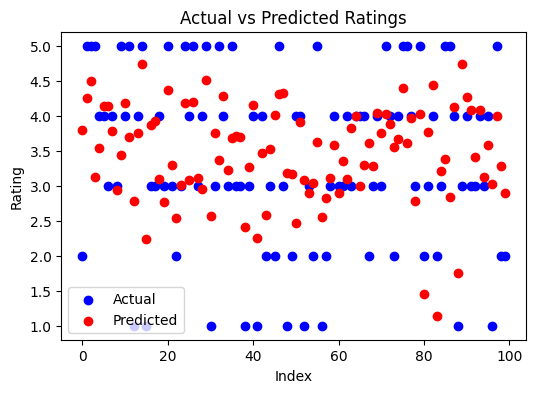

In [63]:
#可视化
comparison = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
comparison_head = comparison.head(100).reset_index()
plt.figure(figsize=(6, 4))
plt.scatter(comparison_head.index, comparison_head['Actual'], color='blue', label='Actual')
plt.scatter(comparison_head.index, comparison_head['Predicted'], color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Rating')
plt.title('Actual vs Predicted Ratings')
plt.legend()
plt.show()

In [19]:
import random

# 从训练集随机抽取五组数据计算得分，并显示真实分数
def random_train_samples_score(train_loader, n_samples=5):
    model.eval()
    with torch.no_grad():
        user_cat_batch, user_cont_batch, item_cat_batch, item_cont_batch, y_batch = next(iter(train_loader))
        sampled_indices = random.sample(range(len(y_batch)), n_samples)
        for idx in sampled_indices:
            user_cat_sample = user_cat_batch[idx].unsqueeze(0)
            user_cont_sample = user_cont_batch[idx].unsqueeze(0)
            item_cat_sample = item_cat_batch[idx].unsqueeze(0)
            item_cont_sample = item_cont_batch[idx].unsqueeze(0)
            true_score = y_batch[idx].item()
            predicted_score = model(user_cat_sample, user_cont_sample, item_cat_sample, item_cont_sample).item()
            print(f"Training sample - True Rating: {true_score:.2f}, Predicted Rating: {predicted_score:.2f}")

# 从测试集随机抽取五个用户数据和电影数据，组合计算推荐得分
def random_test_user_movie_scores(test_loader, test_dataset, n_samples=5):
    model.eval()
    with torch.no_grad():
        for _ in range(n_samples):
            # 从测试集随机抽取一个用户
            user_idx = random.randint(0, len(test_dataset) - 1)
            user_cat_sample, user_cont_sample, _, _, _ = test_dataset[user_idx]
            
            # 从测试集随机抽取一个电影
            item_idx = random.randint(0, len(test_dataset) - 1)
            _, _, item_cat_sample, item_cont_sample, _ = test_dataset[item_idx]
            
            user_cat_sample = user_cat_sample.unsqueeze(0)
            user_cont_sample = user_cont_sample.unsqueeze(0)
            item_cat_sample = item_cat_sample.unsqueeze(0)
            item_cont_sample = item_cont_sample.unsqueeze(0)
            
            predicted_score = model(user_cat_sample, user_cont_sample, item_cat_sample, item_cont_sample).item()
            print(f"Test sample - Predicted Rating: {predicted_score:.2f}")

# 调用函数计算并显示结果
print("Randomly selected training samples:")
random_train_samples_score(train_loader, n_samples=5)
print("\nRandomly selected test samples:")
random_test_user_movie_scores(test_loader, test_dataset, n_samples=5)


Randomly selected training samples:
Training sample - True Rating: 2.00, Predicted Rating: 2.86
Training sample - True Rating: 3.00, Predicted Rating: 3.10
Training sample - True Rating: 4.00, Predicted Rating: 3.95
Training sample - True Rating: 4.00, Predicted Rating: 3.46
Training sample - True Rating: 3.00, Predicted Rating: 3.19

Randomly selected test samples:
Test sample - Predicted Rating: 3.97
Test sample - Predicted Rating: 3.30
Test sample - Predicted Rating: 3.30
Test sample - Predicted Rating: 3.13
Test sample - Predicted Rating: 3.78


In [68]:
#wide&deep在改善了过拟合问题以后依然强势
data1 = pd.read_csv('data1.csv')
data1.drop(data1.columns[0], axis=1, inplace=True)

class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_genre, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_genre = torch.tensor(X_genre.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_genre[idx], self.y[idx]

class WideAndDeepModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, movie_genre_dim):
        super(WideAndDeepModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=0) for input_dim in categorical_dims
        ])
        self.genre_embedding = nn.Linear(movie_genre_dim, embedding_dim)
        self.deep = nn.Sequential(
            nn.Linear(len(categorical_dims) * embedding_dim + embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.wide = nn.Linear(len(categorical_dims) * embedding_dim + embedding_dim, 1)

    def forward(self, x_cat, x_genre):
        x_cat = [self.embeddings[i](x_cat[:, i].clamp(0, self.embeddings[i].num_embeddings - 1)) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x_genre = self.genre_embedding(x_genre)
        x = torch.cat([x_cat, x_genre], dim=1)
        deep_out = self.deep(x)
        wide_out = self.wide(x)
        return wide_out + deep_out

def encode_features(train_df, test_df):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        le = LabelEncoder()
        le.fit(train_df[column])
        encoded_train_df[column] = le.transform(train_df[column])
        encoded_test_df[column] = test_df[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders

y = data1['rating']
X = data1.drop(columns=['rating'])

genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_cols = X.drop(columns=genre_cols).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols])

X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]

train_dataset = MovieRatingDataset(X_train_cat, X_train_genre, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_genre, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

categorical_dims = [X_train[col].nunique() for col in categorical_cols]
model = WideAndDeepModel(categorical_dims, embedding_dim=4, movie_genre_dim=len(genre_cols))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01,weight_decay=1e-4)
num_epochs = 43
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_genre_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_genre_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')

Epoch 1/43, Loss: 1.1350
Epoch 2/43, Loss: 0.9210
Epoch 3/43, Loss: 0.9000
Epoch 4/43, Loss: 0.8844
Epoch 5/43, Loss: 0.8711
Epoch 6/43, Loss: 0.8571
Epoch 7/43, Loss: 0.8477
Epoch 8/43, Loss: 0.8397
Epoch 9/43, Loss: 0.8309
Epoch 10/43, Loss: 0.8218
Epoch 11/43, Loss: 0.8122
Epoch 12/43, Loss: 0.8087
Epoch 13/43, Loss: 0.8047
Epoch 14/43, Loss: 0.8002
Epoch 15/43, Loss: 0.7979
Epoch 16/43, Loss: 0.7957
Epoch 17/43, Loss: 0.7923
Epoch 18/43, Loss: 0.7916
Epoch 19/43, Loss: 0.7902
Epoch 20/43, Loss: 0.7902
Epoch 21/43, Loss: 0.7889
Epoch 22/43, Loss: 0.7873
Epoch 23/43, Loss: 0.7865
Epoch 24/43, Loss: 0.7830
Epoch 25/43, Loss: 0.7833
Epoch 26/43, Loss: 0.7816
Epoch 27/43, Loss: 0.7815
Epoch 28/43, Loss: 0.7825
Epoch 29/43, Loss: 0.7799
Epoch 30/43, Loss: 0.7814
Epoch 31/43, Loss: 0.7827
Epoch 32/43, Loss: 0.7808
Epoch 33/43, Loss: 0.7796
Epoch 34/43, Loss: 0.7799
Epoch 35/43, Loss: 0.7796
Epoch 36/43, Loss: 0.7806
Epoch 37/43, Loss: 0.7767
Epoch 38/43, Loss: 0.7783
Epoch 39/43, Loss: 0.

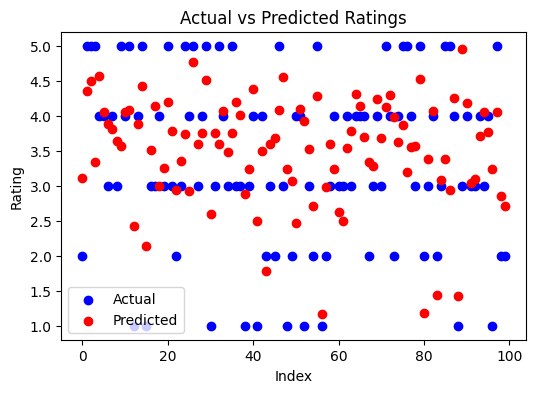

In [69]:
#可视化
comparison = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
comparison_head = comparison.head(100).reset_index()
plt.figure(figsize=(6, 4))
plt.scatter(comparison_head.index, comparison_head['Actual'], color='blue', label='Actual')
plt.scatter(comparison_head.index, comparison_head['Predicted'], color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Rating')
plt.title('Actual vs Predicted Ratings')
plt.legend()
plt.show()

In [70]:
#Deep FM表现挺好 但没我想象的那么好
data1 = pd.read_csv('data1.csv')
data1.drop(data1.columns[0], axis=1, inplace=True)

class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_genre, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_genre = torch.tensor(X_genre.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_genre[idx], self.y[idx]

class DeepFMModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, movie_genre_dim):
        super(DeepFMModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=0) for input_dim in categorical_dims
        ])
        self.genre_embedding = nn.Linear(movie_genre_dim, embedding_dim)
        self.deep = nn.Sequential(
            nn.Linear(len(categorical_dims) * embedding_dim + embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        # FM part
        self.linear = nn.Linear(len(categorical_dims) * embedding_dim + embedding_dim, 1)
        self.fm_embedding = nn.Embedding(len(categorical_dims) * embedding_dim + embedding_dim, embedding_dim)
    
    def forward(self, x_cat, x_genre):
        x_cat = [self.embeddings[i](x_cat[:, i].clamp(0, self.embeddings[i].num_embeddings - 1)) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x_genre = self.genre_embedding(x_genre)
        x = torch.cat([x_cat, x_genre], dim=1)

        deep_out = self.deep(x)

        linear_out = self.linear(x)
        fm_embedding = self.fm_embedding(torch.arange(x.size(1), device=x.device))
        fm_out = 0.5 * torch.sum(
            torch.pow(torch.matmul(x, fm_embedding.T), 2) - torch.matmul(torch.pow(x, 2), torch.pow(fm_embedding, 2).T),
            dim=1,
            keepdim=True
        )
        return linear_out + fm_out + deep_out

def encode_features(train_df, test_df):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        le = LabelEncoder()
        le.fit(train_df[column])
        encoded_train_df[column] = le.transform(train_df[column])
        encoded_test_df[column] = test_df[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders

y = data1['rating']
X = data1.drop(columns=['rating'])

genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_cols = X.drop(columns=genre_cols).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols])

X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]

train_dataset = MovieRatingDataset(X_train_cat, X_train_genre, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_genre, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

categorical_dims = [X_train[col].nunique() for col in categorical_cols]
model = WideAndDeepModel(categorical_dims, embedding_dim=4, movie_genre_dim=len(genre_cols))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01,weight_decay=1e-4)
num_epochs = 43
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_genre_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_genre_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')

Epoch 1/43, Loss: 1.1121
Epoch 2/43, Loss: 0.9148
Epoch 3/43, Loss: 0.8945
Epoch 4/43, Loss: 0.8790
Epoch 5/43, Loss: 0.8676
Epoch 6/43, Loss: 0.8585
Epoch 7/43, Loss: 0.8486
Epoch 8/43, Loss: 0.8371
Epoch 9/43, Loss: 0.8300
Epoch 10/43, Loss: 0.8213
Epoch 11/43, Loss: 0.8145
Epoch 12/43, Loss: 0.8113
Epoch 13/43, Loss: 0.8075
Epoch 14/43, Loss: 0.8036
Epoch 15/43, Loss: 0.7986
Epoch 16/43, Loss: 0.7950
Epoch 17/43, Loss: 0.7923
Epoch 18/43, Loss: 0.7880
Epoch 19/43, Loss: 0.7867
Epoch 20/43, Loss: 0.7875
Epoch 21/43, Loss: 0.7838
Epoch 22/43, Loss: 0.7821
Epoch 23/43, Loss: 0.7824
Epoch 24/43, Loss: 0.7791
Epoch 25/43, Loss: 0.7801
Epoch 26/43, Loss: 0.7771
Epoch 27/43, Loss: 0.7762
Epoch 28/43, Loss: 0.7758
Epoch 29/43, Loss: 0.7762
Epoch 30/43, Loss: 0.7756
Epoch 31/43, Loss: 0.7749
Epoch 32/43, Loss: 0.7730
Epoch 33/43, Loss: 0.7753
Epoch 34/43, Loss: 0.7723
Epoch 35/43, Loss: 0.7699
Epoch 36/43, Loss: 0.7721
Epoch 37/43, Loss: 0.7714
Epoch 38/43, Loss: 0.7726
Epoch 39/43, Loss: 0.

In [4]:
from collections import defaultdict
#对于新用户空白映射，对于新物品按照最热门的映射——双塔
# 数据集类定义
class MovieRatingDataset(Dataset):
    def __init__(self, X_cat_user, X_cont_user, X_cat_item, X_cont_item, y):
        self.X_cat_user = torch.tensor(X_cat_user.values, dtype=torch.long)
        self.X_cont_user = torch.tensor(X_cont_user, dtype=torch.float32)
        self.X_cat_item = torch.tensor(X_cat_item.values, dtype=torch.long)
        self.X_cont_item = torch.tensor(X_cont_item, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat_user[idx], self.X_cont_user[idx], self.X_cat_item[idx], self.X_cont_item[idx], self.y[idx]

# 双塔模型类定义
class TwoTowerModel(nn.Module):
    def __init__(self, user_dims, item_dims, embedding_dim, num_user_cont_features, num_item_cont_features):
        super(TwoTowerModel, self).__init__()
        # 用户塔
        self.user_embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=input_dim) for input_dim in user_dims
        ])
        self.user_deep = nn.Sequential(
            nn.Linear(len(user_dims) * embedding_dim + num_user_cont_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        # 物品塔
        self.item_embeddings = nn.ModuleList([
            nn.Embedding(input_dim, embedding_dim) for input_dim in item_dims
        ])
        self.item_deep = nn.Sequential(
            nn.Linear(len(item_dims) * embedding_dim + num_item_cont_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
    
    def forward(self, user_cat, user_cont, item_cat, item_cont):
        # 用户塔前向传播
        user_cat_embeds = [self.user_embeddings[i](user_cat[:, i]) for i in range(len(self.user_embeddings))]
        user_cat_embeds = torch.cat(user_cat_embeds, dim=1)
        user_input = torch.cat([user_cat_embeds, user_cont], dim=1)
        user_out = self.user_deep(user_input)
        # 物品塔前向传播
        item_cat_embeds = [self.item_embeddings[i](item_cat[:, i]) for i in range(len(self.item_embeddings))]
        item_cat_embeds = torch.cat(item_cat_embeds, dim=1)
        item_input = torch.cat([item_cat_embeds, item_cont], dim=1)
        item_out = self.item_deep(item_input)
        similarity = F.cosine_similarity(user_out, item_out)
        # 将相似度映射到评分范围
        rating = (similarity + 1) * 2.5  # [-1, 1] -> [0, 2] -> [0, 5]
        return rating

# 优化后的特征编码函数 - 用户塔
def encode_user_features_with_padding(df, label_encoders=None):
    encoded_df = df.copy()
    if label_encoders is None:
        label_encoders = {}
        for column in df.columns:
            le = LabelEncoder()
            le.fit(df[column])
            encoded_df[column] = le.transform(df[column])
            label_encoders[column] = le
    else:
        for column in df.columns:
            le = label_encoders[column]
            # 将未见过的值编码为 len(le.classes_)
            unknown_label = len(le.classes_)
            encoded_df[column] = df[column].map(lambda x: le.transform([x])[0] if x in le.classes_ else unknown_label)
    return encoded_df, label_encoders

# 优化后的特征编码函数 - 物品塔
def encode_item_features_with_frequency(df, label_encoders=None):
    encoded_df = df.copy()
    id_frequency = defaultdict(int)
    if label_encoders is None:
        label_encoders = {}
        for column in df.columns:
            le = LabelEncoder()
            le.fit(df[column])
            label_encoders[column] = le
            id_frequency[column] = df[column].value_counts(normalize=True).to_dict()
    else:
        for column in df.columns:
            le = label_encoders[column]
            id_frequency[column] = df[column].value_counts(normalize=True).to_dict()
    
    def get_encoded_value(column, value):
        le = label_encoders[column]
        if value in le.classes_:
            return le.transform([value])[0]
        else:
            # 提前计算好最频繁值，避免每次查找
            most_frequent_value = max(id_frequency[column], key=id_frequency[column].get)
            return le.transform([most_frequent_value])[0]

    for column in df.columns:
        encoded_df[column] = df[column].apply(lambda x: get_encoded_value(column, x))
    
    return encoded_df, label_encoders



In [5]:
# 数据准备和模型训练
data1 = pd.read_csv('data1.csv')
data1.drop(data1.columns[0], axis=1, inplace=True)

y = data1['rating']
X = data1.drop(columns=['rating'])

continuous_cols_user = ['timestamp', 'user id', 'age']
continuous_cols_item = ['release_date', 'item id']
categorical_cols_user = ["gender", "occupation", "zip code"]
categorical_cols_item = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_user_cat, user_label_encoders = encode_user_features_with_padding(X_train[categorical_cols_user])
X_test_user_cat, _ = encode_user_features_with_padding(X_test[categorical_cols_user], user_label_encoders)

X_train_item_cat, item_label_encoders = encode_item_features_with_frequency(X_train[categorical_cols_item])
X_test_item_cat, _ = encode_item_features_with_frequency(X_test[categorical_cols_item], item_label_encoders)

scaler_user = StandardScaler()
X_train_user_cont = scaler_user.fit_transform(X_train[continuous_cols_user])
X_test_user_cont = scaler_user.transform(X_test[continuous_cols_user])

scaler_item = StandardScaler()
X_train_item_cont = scaler_item.fit_transform(X_train[continuous_cols_item])
X_test_item_cont = scaler_item.transform(X_test[continuous_cols_item])

train_dataset = MovieRatingDataset(X_train_user_cat, X_train_user_cont, X_train_item_cat, X_train_item_cont, y_train)
test_dataset = MovieRatingDataset(X_test_user_cat, X_test_user_cont, X_test_item_cat, X_test_item_cont, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [7]:
# 根据特征维度初始化双塔模型#Mmoe是多任务，用不了
user_dims = [X_train_user_cat[col].nunique() for col in categorical_cols_user] 
item_dims = [X_train_item_cat[col].nunique() for col in categorical_cols_item]
model = TwoTowerModel(user_dims, item_dims, embedding_dim=8, num_user_cont_features=len(continuous_cols_user), num_item_cont_features=len(continuous_cols_item))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for user_cat_batch, user_cont_batch, item_cat_batch, item_cont_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(user_cat_batch, user_cont_batch, item_cat_batch, item_cont_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * user_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for user_cat_batch, user_cont_batch, item_cat_batch, item_cont_batch, _ in test_loader:
        outputs = model(user_cat_batch, user_cont_batch, item_cat_batch, item_cont_batch).squeeze()
        y_pred.extend(outputs.numpy())

y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')

Epoch 1/50, Loss: 1.1125
Epoch 2/50, Loss: 1.0244
Epoch 3/50, Loss: 0.9936
Epoch 4/50, Loss: 0.9772
Epoch 5/50, Loss: 0.9651
Epoch 6/50, Loss: 0.9550
Epoch 7/50, Loss: 0.9449
Epoch 8/50, Loss: 0.9353
Epoch 9/50, Loss: 0.9287
Epoch 10/50, Loss: 0.9211
Epoch 11/50, Loss: 0.9143
Epoch 12/50, Loss: 0.9049
Epoch 13/50, Loss: 0.8985
Epoch 14/50, Loss: 0.8930
Epoch 15/50, Loss: 0.8872
Epoch 16/50, Loss: 0.8847
Epoch 17/50, Loss: 0.8795
Epoch 18/50, Loss: 0.8742
Epoch 19/50, Loss: 0.8702
Epoch 20/50, Loss: 0.8663
Epoch 21/50, Loss: 0.8620
Epoch 22/50, Loss: 0.8597
Epoch 23/50, Loss: 0.8558
Epoch 24/50, Loss: 0.8522
Epoch 25/50, Loss: 0.8501
Epoch 26/50, Loss: 0.8479
Epoch 27/50, Loss: 0.8418
Epoch 28/50, Loss: 0.8411
Epoch 29/50, Loss: 0.8376
Epoch 30/50, Loss: 0.8364
Epoch 31/50, Loss: 0.8320
Epoch 32/50, Loss: 0.8291
Epoch 33/50, Loss: 0.8270
Epoch 34/50, Loss: 0.8244
Epoch 35/50, Loss: 0.8224
Epoch 36/50, Loss: 0.8198
Epoch 37/50, Loss: 0.8165
Epoch 38/50, Loss: 0.8151
Epoch 39/50, Loss: 0.

In [21]:
#deep&cross 加了多阶交叉特征以后，不仅表达更好了，效果也更好了，不过图像上看起来没有特别明显
data1 = pd.read_csv('data1.csv')
data1.drop(data1.columns[0], axis=1, inplace=True)

class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_genre, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_genre = torch.tensor(X_genre.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_genre[idx], self.y[idx]
class CrossNetwork(nn.Module):
    def __init__(self, input_dim, num_layers):
        super(CrossNetwork, self).__init__()
        self.num_layers = num_layers
        self.cross_layers = nn.ModuleList([nn.Linear(input_dim, input_dim, bias=True) for _ in range(num_layers)])
        self.output_layer = nn.Linear(input_dim, 1)  # New output layer to reduce dimension to 1

    def forward(self, x):
        x0 = x
        for i in range(self.num_layers):
            xl_w = self.cross_layers[i](x)  
            x = x0 * xl_w + x
        x = self.output_layer(x) 
        return x

class DeepNetwork(nn.Module):
    def __init__(self, input_dim):
        super(DeepNetwork, self).__init__()
        self.deep = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.deep(x)

class DeepAndCrossModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, movie_genre_dim, num_cross_layers):
        super(DeepAndCrossModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=0) for input_dim in categorical_dims
        ])
        self.genre_embedding = nn.Linear(movie_genre_dim, embedding_dim)
        input_dim = len(categorical_dims) * embedding_dim + embedding_dim
        self.cross_network = CrossNetwork(input_dim, num_cross_layers)
        self.deep_network = DeepNetwork(input_dim)
    
    def forward(self, x_cat, x_genre):
        x_cat = [self.embeddings[i](x_cat[:, i].clamp(0, self.embeddings[i].num_embeddings - 1)) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x_genre = self.genre_embedding(x_genre)
        x = torch.cat([x_cat, x_genre], dim=1)
        
        cross_out = self.cross_network(x)
        deep_out = self.deep_network(x)
        return cross_out + deep_out

def encode_features(train_df, test_df):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        le = LabelEncoder()
        le.fit(train_df[column])
        encoded_train_df[column] = le.transform(train_df[column])
        encoded_test_df[column] = test_df[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders

y = data1['rating']
X = data1.drop(columns=['rating'])
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_cols = X.drop(columns=genre_cols).columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols])
X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]
train_dataset = MovieRatingDataset(X_train_cat, X_train_genre, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_genre, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
categorical_dims = [X_train[col].nunique() for col in categorical_cols]

model = DeepAndCrossModel(categorical_dims, embedding_dim=4, movie_genre_dim=len(genre_cols), num_cross_layers=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
num_epochs = 43
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_genre_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_genre_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')

Epoch 1/43, Loss: 1.1563
Epoch 2/43, Loss: 0.9386
Epoch 3/43, Loss: 0.8996
Epoch 4/43, Loss: 0.8775
Epoch 5/43, Loss: 0.8625
Epoch 6/43, Loss: 0.8456
Epoch 7/43, Loss: 0.8285
Epoch 8/43, Loss: 0.8146
Epoch 9/43, Loss: 0.8060
Epoch 10/43, Loss: 0.7958
Epoch 11/43, Loss: 0.7885
Epoch 12/43, Loss: 0.7827
Epoch 13/43, Loss: 0.7790
Epoch 14/43, Loss: 0.7756
Epoch 15/43, Loss: 0.7721
Epoch 16/43, Loss: 0.7690
Epoch 17/43, Loss: 0.7668
Epoch 18/43, Loss: 0.7664
Epoch 19/43, Loss: 0.7647
Epoch 20/43, Loss: 0.7625
Epoch 21/43, Loss: 0.7605
Epoch 22/43, Loss: 0.7614
Epoch 23/43, Loss: 0.7597
Epoch 24/43, Loss: 0.7588
Epoch 25/43, Loss: 0.7607
Epoch 26/43, Loss: 0.7585
Epoch 27/43, Loss: 0.7582
Epoch 28/43, Loss: 0.7563
Epoch 29/43, Loss: 0.7567
Epoch 30/43, Loss: 0.7557
Epoch 31/43, Loss: 0.7565
Epoch 32/43, Loss: 0.7568
Epoch 33/43, Loss: 0.7568
Epoch 34/43, Loss: 0.7554
Epoch 35/43, Loss: 0.7561
Epoch 36/43, Loss: 0.7559
Epoch 37/43, Loss: 0.7579
Epoch 38/43, Loss: 0.7541
Epoch 39/43, Loss: 0.

In [24]:
#残差连接 表现是不好的，显然，层数太浅，对信息的提取不够深度才是重点
data1 = pd.read_csv('data1.csv')
data1.drop(data1.columns[0], axis=1, inplace=True)

class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_genre, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_genre = torch.tensor(X_genre.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_genre[idx], self.y[idx]

class WideAndDeepModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, movie_genre_dim):
        super(WideAndDeepModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=0) for input_dim in categorical_dims
        ])
        self.genre_embedding = nn.Linear(movie_genre_dim, embedding_dim)
        self.deep = nn.Sequential(
            nn.Linear(len(categorical_dims) * embedding_dim + embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.wide = nn.Linear(len(categorical_dims) * embedding_dim + embedding_dim, 1)
        self.residual_layer1 = nn.Linear(len(categorical_dims) * embedding_dim + embedding_dim, 64)
        self.residual_layer2 = nn.Linear(64, 64)
        self.residual_layer3 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x_cat, x_genre):
        x_cat = [self.embeddings[i](x_cat[:, i].clamp(0, self.embeddings[i].num_embeddings - 1)) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x_genre = self.genre_embedding(x_genre)
        x = torch.cat([x_cat, x_genre], dim=1)
        x_res1 = self.residual_layer1(x)
        deep_out1 = self.deep[1](x_res1) + x_res1  # 残差连接
        x_res2 = self.residual_layer2(deep_out1)
        deep_out2 = self.deep[3](x_res2) + x_res2  # 残差连接
        x_res3 = self.residual_layer3(deep_out2)
        deep_out3 = self.deep[5](x_res3) + x_res3  # 残差连接
        deep_out = self.output_layer(deep_out3)
        wide_out = self.wide(x)
        return wide_out + deep_out

def encode_features(train_df, test_df):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        le = LabelEncoder()
        le.fit(train_df[column])
        encoded_train_df[column] = le.transform(train_df[column])
        encoded_test_df[column] = test_df[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders

y = data1['rating']
X = data1.drop(columns=['rating'])

genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_cols = X.drop(columns=genre_cols).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols])

X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]

train_dataset = MovieRatingDataset(X_train_cat, X_train_genre, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_genre, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

categorical_dims = [X_train[col].nunique() for col in categorical_cols]
model = WideAndDeepModel(categorical_dims, embedding_dim=4, movie_genre_dim=len(genre_cols))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01,weight_decay=1e-4)
num_epochs = 43
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_genre_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_genre_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')

Epoch 1/43, Loss: 1.1569
Epoch 2/43, Loss: 0.9168
Epoch 3/43, Loss: 0.8943
Epoch 4/43, Loss: 0.8892
Epoch 5/43, Loss: 0.8827
Epoch 6/43, Loss: 0.8823
Epoch 7/43, Loss: 0.8804
Epoch 8/43, Loss: 0.9734
Epoch 9/43, Loss: 0.8793
Epoch 10/43, Loss: 0.8779
Epoch 11/43, Loss: 0.8777
Epoch 12/43, Loss: 0.8776
Epoch 13/43, Loss: 0.8775
Epoch 14/43, Loss: 0.8777
Epoch 15/43, Loss: 0.8909
Epoch 16/43, Loss: 0.8780
Epoch 17/43, Loss: 0.8782
Epoch 18/43, Loss: 0.8779
Epoch 19/43, Loss: 0.8769
Epoch 20/43, Loss: 0.9591
Epoch 21/43, Loss: 0.8788
Epoch 22/43, Loss: 0.8767
Epoch 23/43, Loss: 0.8775
Epoch 24/43, Loss: 0.8770
Epoch 25/43, Loss: 0.8771
Epoch 26/43, Loss: 0.8772
Epoch 27/43, Loss: 0.8870
Epoch 28/43, Loss: 0.8789
Epoch 29/43, Loss: 0.8771
Epoch 30/43, Loss: 0.8768
Epoch 31/43, Loss: 0.8771
Epoch 32/43, Loss: 2.7562
Epoch 33/43, Loss: 0.9065
Epoch 34/43, Loss: 0.8811
Epoch 35/43, Loss: 0.8769
Epoch 36/43, Loss: 0.8755
Epoch 37/43, Loss: 0.8763
Epoch 38/43, Loss: 0.8773
Epoch 39/43, Loss: 0.

In [25]:
#deep&cross 如果交叉特征翻倍 deep&cross本质还是为了处理显式的低阶交叉特征，更高阶的角色和deep有些重合。所以表现不如前者
data1 = pd.read_csv('data1.csv')
data1.drop(data1.columns[0], axis=1, inplace=True)

class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_genre, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_genre = torch.tensor(X_genre.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_genre[idx], self.y[idx]
class CrossNetwork(nn.Module):
    def __init__(self, input_dim, num_layers):
        super(CrossNetwork, self).__init__()
        self.num_layers = num_layers
        self.cross_layers = nn.ModuleList([nn.Linear(input_dim, input_dim, bias=True) for _ in range(num_layers)])
        self.output_layer = nn.Linear(input_dim, 1)  # New output layer to reduce dimension to 1

    def forward(self, x):
        x0 = x
        for i in range(self.num_layers):
            xl_w = self.cross_layers[i](x)  
            x = x0 * xl_w + x
        x = self.output_layer(x) 
        return x

class DeepNetwork(nn.Module):
    def __init__(self, input_dim):
        super(DeepNetwork, self).__init__()
        self.deep = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.deep(x)

class DeepAndCrossModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, movie_genre_dim, num_cross_layers):
        super(DeepAndCrossModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=0) for input_dim in categorical_dims
        ])
        self.genre_embedding = nn.Linear(movie_genre_dim, embedding_dim)
        input_dim = len(categorical_dims) * embedding_dim + embedding_dim
        self.cross_network = CrossNetwork(input_dim, num_cross_layers)
        self.deep_network = DeepNetwork(input_dim)
    
    def forward(self, x_cat, x_genre):
        x_cat = [self.embeddings[i](x_cat[:, i].clamp(0, self.embeddings[i].num_embeddings - 1)) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x_genre = self.genre_embedding(x_genre)
        x = torch.cat([x_cat, x_genre], dim=1)
        
        cross_out = self.cross_network(x)
        deep_out = self.deep_network(x)
        return cross_out + deep_out

def encode_features(train_df, test_df):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        le = LabelEncoder()
        le.fit(train_df[column])
        encoded_train_df[column] = le.transform(train_df[column])
        encoded_test_df[column] = test_df[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders

y = data1['rating']
X = data1.drop(columns=['rating'])
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_cols = X.drop(columns=genre_cols).columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols])
X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]
train_dataset = MovieRatingDataset(X_train_cat, X_train_genre, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_genre, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
categorical_dims = [X_train[col].nunique() for col in categorical_cols]

model = DeepAndCrossModel(categorical_dims, embedding_dim=4, movie_genre_dim=len(genre_cols), num_cross_layers=6)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
num_epochs = 43
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_genre_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_genre_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')

Epoch 1/43, Loss: 1.1711
Epoch 2/43, Loss: 0.9390
Epoch 3/43, Loss: 0.8956
Epoch 4/43, Loss: 0.8750
Epoch 5/43, Loss: 0.8562
Epoch 6/43, Loss: 0.8411
Epoch 7/43, Loss: 0.8231
Epoch 8/43, Loss: 0.8145
Epoch 9/43, Loss: 0.8071
Epoch 10/43, Loss: 0.7991
Epoch 11/43, Loss: 0.7965
Epoch 12/43, Loss: 0.7926
Epoch 13/43, Loss: 0.7886
Epoch 14/43, Loss: 0.7866
Epoch 15/43, Loss: 0.7835
Epoch 16/43, Loss: 0.7808
Epoch 17/43, Loss: 0.7795
Epoch 18/43, Loss: 0.7771
Epoch 19/43, Loss: 0.7768
Epoch 20/43, Loss: 0.7765
Epoch 21/43, Loss: 0.7764
Epoch 22/43, Loss: 0.7737
Epoch 23/43, Loss: 0.7745
Epoch 24/43, Loss: 0.7722
Epoch 25/43, Loss: 0.7765
Epoch 26/43, Loss: 0.7739
Epoch 27/43, Loss: 0.7730
Epoch 28/43, Loss: 0.7725
Epoch 29/43, Loss: 0.7708
Epoch 30/43, Loss: 0.7740
Epoch 31/43, Loss: 0.7696
Epoch 32/43, Loss: 0.7689
Epoch 33/43, Loss: 0.7703
Epoch 34/43, Loss: 0.7690
Epoch 35/43, Loss: 0.7695
Epoch 36/43, Loss: 0.7683
Epoch 37/43, Loss: 0.7675
Epoch 38/43, Loss: 0.7704
Epoch 39/43, Loss: 0.